In [1]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    "pgf.rcfonts" : False
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [4]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.6 meter of center of road

In [5]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        orientation_error = np.tan(alpha + t)*camera_height - ground_distance
    else:
        orientation_error = 0
        
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [6]:
def error_radius_across_pixels(camera, fraction_to_sample=0.5):
    # though this has some randomness associated
    # with a perspective model, pretty much all values are the same across a single X line
    # so to speed this up I'll just do a couple of columns, then repeat it as required
    # to obtain the right image size
    
    # FALSE -- not true! error is lower in the middle!! 
    # => just cut computation time half and reflect
    
    image = np.zeros(shape=(camera.R_y, camera.R_x))
    
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])
    
    columns_to_sample = int(camera.R_x * fraction_to_sample)
    sampled = np.zeros(shape=(camera.R_y, columns_to_sample))
    step = camera.R_x/columns_to_sample # step across image, this makes it usable even in different models with less loss

    for (y,x), _ in np.ndenumerate(sampled):
        x_pix = x * step # take x steps
        ground_point = camera.pixel_to_plane(x_pix, y)
        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)
        pixel_area = camera.plane_area_of_pixel(x_pix,y)
        sampled[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]
    
    # repeat the samples to fill the image
    repeats = step
    partial_fill = np.repeat(sampled, repeats).reshape(camera.R_y, -1)
    remaining_cols = image.shape[1] - partial_fill.shape[1]
    if remaining_cols > 0:
        image[:, partial_fill.shape[1]:] = sampled[:, :remaining_cols]
    image[:, :partial_fill.shape[1]] = partial_fill
    
    return image
        

In [7]:
camera = Camera(np.array([0,0,6]), 60.0, 0.0)
camera.set_resolution(200, 200)
image = error_radius_across_pixels(camera, fraction_to_sample=0.5) #

KeyboardInterrupt: 

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [10]:
save_dir = 'data/straight_road/'

camera_height = 6.0
resolution = (200, 200)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 10.0 # doesn't really matter

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range, 5.0)

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+error_bounds)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 0.917807358254
Processing: pitch -- 34.0, yaw -- 0.0
Score: 1.13929834505
Processing: pitch -- 37.0, yaw -- 0.0
Score: 1.35554058489
Processing: pitch -- 40.0, yaw -- 0.0
Score: 1.55377691225
Processing: pitch -- 43.0, yaw -- 0.0
Score: 1.7532181545
Processing: pitch -- 46.0, yaw -- 0.0
Score: 1.92616359734
Processing: pitch -- 49.0, yaw -- 0.0
Score: 2.1033888762
Processing: pitch -- 52.0, yaw -- 0.0
Score: 2.27187058162
Processing: pitch -- 55.0, yaw -- 0.0
Score: 2.45142682991
Processing: pitch -- 58.0, yaw -- 0.0
Score: 2.63146324856
Processing: pitch -- 61.0, yaw -- 0.0
Score: 2.84071908449
Processing: pitch -- 64.0, yaw -- 0.0
Score: 3.05375802878
Processing: pitch -- 67.0, yaw -- 0.0
Score: 3.29596594173
Processing: pitch -- 70.0, yaw -- 0.0
Score: 3.55823729321
Processing: pitch -- 73.0, yaw -- 0.0
Score: 3.84090308961
Processing: pitch -- 76.0, yaw -- 0.0
Score: 4.15562299937
Processing: pitch -- 79.0, yaw -- 0.0
Score: 4.5042543853

Score: 2.97685917913
Processing: pitch -- 67.0, yaw -- 30.0
Score: 2.98907370725
Processing: pitch -- 70.0, yaw -- 30.0
Score: 3.02398112564
Processing: pitch -- 73.0, yaw -- 30.0
Score: 3.08219562855
Processing: pitch -- 76.0, yaw -- 30.0
Score: 3.14215662331
Processing: pitch -- 79.0, yaw -- 30.0
Score: 3.04242678502
Processing: pitch -- 82.0, yaw -- 30.0
Score: 2.92831381368
Processing: pitch -- 85.0, yaw -- 30.0
Score: 2.80228887263
Processing: pitch -- 88.0, yaw -- 30.0
Score: 2.66198627681
Processing: pitch -- 91.0, yaw -- 30.0
Score: 2.50455272583
Processing: pitch -- 31.0, yaw -- 35.0
Score: 1.41533825198
Processing: pitch -- 34.0, yaw -- 35.0
Score: 1.67278955386
Processing: pitch -- 37.0, yaw -- 35.0
Score: 1.93284434872
Processing: pitch -- 40.0, yaw -- 35.0
Score: 2.19024117293
Processing: pitch -- 43.0, yaw -- 35.0
Score: 2.45490402758
Processing: pitch -- 46.0, yaw -- 35.0
Score: 2.71604568286
Processing: pitch -- 49.0, yaw -- 35.0
Score: 2.94625276015
Processing: pitch -

Score: 2.67145406831
Processing: pitch -- 37.0, yaw -- 65.0
Score: 3.23142531794
Processing: pitch -- 40.0, yaw -- 65.0
Score: 3.78207183612
Processing: pitch -- 43.0, yaw -- 65.0
Score: 4.11738889568
Processing: pitch -- 46.0, yaw -- 65.0
Score: 3.98812641811
Processing: pitch -- 49.0, yaw -- 65.0
Score: 3.75802531775
Processing: pitch -- 52.0, yaw -- 65.0
Score: 3.58418424566
Processing: pitch -- 55.0, yaw -- 65.0
Score: 3.45709265408
Processing: pitch -- 58.0, yaw -- 65.0
Score: 3.36611245114
Processing: pitch -- 61.0, yaw -- 65.0
Score: 3.30942792138
Processing: pitch -- 64.0, yaw -- 65.0
Score: 3.28412436185
Processing: pitch -- 67.0, yaw -- 65.0
Score: 3.28791703528
Processing: pitch -- 70.0, yaw -- 65.0
Score: 3.32122865317
Processing: pitch -- 73.0, yaw -- 65.0
Score: 3.38625748116
Processing: pitch -- 76.0, yaw -- 65.0
Score: 3.48396051492
Processing: pitch -- 79.0, yaw -- 65.0
Score: 3.61975798213
Processing: pitch -- 82.0, yaw -- 65.0
Score: 3.63159815278
Processing: pitch -

Score: 3.96742627632
Processing: pitch -- 70.0, yaw -- 95.0
Score: 3.98579607857
Processing: pitch -- 73.0, yaw -- 95.0
Score: 4.03421473385
Processing: pitch -- 76.0, yaw -- 95.0
Score: 4.11415967778
Processing: pitch -- 79.0, yaw -- 95.0
Score: 4.22796112263
Processing: pitch -- 82.0, yaw -- 95.0
Score: 4.37850282602
Processing: pitch -- 85.0, yaw -- 95.0
Score: 4.57021536928
Processing: pitch -- 88.0, yaw -- 95.0
Score: 4.79663645982
Processing: pitch -- 91.0, yaw -- 95.0
Score: 4.39605227822
Processing: pitch -- 31.0, yaw -- 100.0
Score: 2.07964830842
Processing: pitch -- 34.0, yaw -- 100.0
Score: 4.13772918494
Processing: pitch -- 37.0, yaw -- 100.0
Score: 5.60085849643
Processing: pitch -- 40.0, yaw -- 100.0
Score: 5.66326051005
Processing: pitch -- 43.0, yaw -- 100.0
Score: 5.24736095874
Processing: pitch -- 46.0, yaw -- 100.0
Score: 4.91320993224
Processing: pitch -- 49.0, yaw -- 100.0
Score: 4.65507173357
Processing: pitch -- 52.0, yaw -- 100.0
Score: 4.45474646037
Processing:

Score: 2.49078394651
Processing: pitch -- 34.0, yaw -- 130.0
Score: 2.92760875392
Processing: pitch -- 37.0, yaw -- 130.0
Score: 3.34838208448
Processing: pitch -- 40.0, yaw -- 130.0
Score: 3.75630418381
Processing: pitch -- 43.0, yaw -- 130.0
Score: 4.15253072742
Processing: pitch -- 46.0, yaw -- 130.0
Score: 4.46563660727
Processing: pitch -- 49.0, yaw -- 130.0
Score: 4.51760807378
Processing: pitch -- 52.0, yaw -- 130.0
Score: 4.38122473237
Processing: pitch -- 55.0, yaw -- 130.0
Score: 4.24567530365
Processing: pitch -- 58.0, yaw -- 130.0
Score: 4.14821433098
Processing: pitch -- 61.0, yaw -- 130.0
Score: 4.08491473461
Processing: pitch -- 64.0, yaw -- 130.0
Score: 4.05261369776
Processing: pitch -- 67.0, yaw -- 130.0
Score: 4.04376774301
Processing: pitch -- 70.0, yaw -- 130.0
Score: 4.05594689503
Processing: pitch -- 73.0, yaw -- 130.0
Score: 4.08340987361
Processing: pitch -- 76.0, yaw -- 130.0
Score: 4.09596365014
Processing: pitch -- 79.0, yaw -- 130.0
Score: 3.84710929146
Pro

Score: 3.44649146295
Processing: pitch -- 61.0, yaw -- 160.0
Score: 3.45206986429
Processing: pitch -- 64.0, yaw -- 160.0
Score: 3.44772731569
Processing: pitch -- 67.0, yaw -- 160.0
Score: 3.45142619537
Processing: pitch -- 70.0, yaw -- 160.0
Score: 3.47202420977
Processing: pitch -- 73.0, yaw -- 160.0
Score: 3.51357387848
Processing: pitch -- 76.0, yaw -- 160.0
Score: 3.51175072397
Processing: pitch -- 79.0, yaw -- 160.0
Score: 3.36881400688
Processing: pitch -- 82.0, yaw -- 160.0
Score: 3.2168333948
Processing: pitch -- 85.0, yaw -- 160.0
Score: 3.05576784346
Processing: pitch -- 88.0, yaw -- 160.0
Score: 2.88434719885
Processing: pitch -- 91.0, yaw -- 160.0
Score: 2.70098141418
Processing: pitch -- 31.0, yaw -- 165.0
Score: 1.5829645397
Processing: pitch -- 34.0, yaw -- 165.0
Score: 1.83265737787
Processing: pitch -- 37.0, yaw -- 165.0
Score: 2.07644234769
Processing: pitch -- 40.0, yaw -- 165.0
Score: 2.31518129262
Processing: pitch -- 43.0, yaw -- 165.0
Score: 2.5485470104
Proces

In [11]:
# save above to file to not lose it! very expensive computation
np.save("straight_road_300x300_6m_pitch_yaw_scores_0-4_two_stddev.npy", scores)

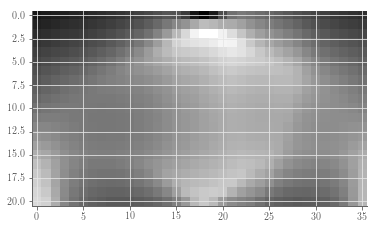

In [12]:
plt.imshow(scores)
plt.gray()
plt.show()

In [ ]:
# Hill climbing with random restarts

def random_restart_hillclimb(score_function, parameter_ranges, finish_epsilon=0.1, parameter_step_fraction=0.01, acceleration=1.2, num_restarts=100, initialization_generator=None):
    
    local_score_maxima = []
    local_maxima_params = []
    
    for _ in range(num_restarts):
        if initialization_generator is not None:
            init_params = initialization_generator(parameter_ranges)
        else:
            init_params = None
            
        score, params = hillclimb(score_function, parameter_ranges, parameter_initializations=init_params, finish_epsilon=finish_epsilon, parameter_step_fraction=parameter_step_fraction, acceleration=acceleration)
        
        print("{0}, params: {1}".format(score, params))
        
        local_score_maxima.append(score)
        local_maxima_params.append(params)
    return (local_score_maxima, local_maxima_params)
        

In [ ]:
camera_height = 6.0
resolution = (150, 150)
fov_deg = (60.0, 60.0)
yaw_range = 60 # degrees +- from center yaw position

curvature = 0.0
length = 10.0 # doesn't really matter

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitch_range = np.array([31.0, 85.0])

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws_range = np.array([center_yaw_deg - yaw_range, center_yaw_deg + yaw_range])

